# Import library 

### Use of ml_loader

In [ ]:
import ml_loader as ml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import joblib

# Load Data

In [5]:
data = ml.load_data('Telco_customer_churn.xlsx')  

# Show basic info

In [ ]:
print(data.info())
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

# Define the target

In [ ]:
target = 'Churn Value'  # Use 'Churn Label' if you want to work with Yes/No labels
X = data.drop(columns=[target])
y = data[target]

# If using 'Churn Label' (Yes/No), convert it to binary
if target == 'Churn Label':
    le = LabelEncoder()
    y = le.fit_transform(y)  # 'Yes' -> 1, 'No' -> 0


In [8]:
print(y.unique())  # This should print `[0, 1]` if using 'Churn Label' or directly from 'Churn Value'


[1 0]


# Handling missing values

In [ ]:
# Fill numerical NaNs with the median
for column in X.select_dtypes(include=['float64', 'int64']).columns:
    X[column] = X[column].fillna(X[column].median())

# Fill categorical NaNs with the mode
for column in X.select_dtypes(include=['object']).columns:
    X[column] = X[column].fillna(X[column].mode().iloc[0])


/tmp/ipykernel_11268/1930495917.py:8: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  X[column] = X[column].fillna(X[column].mode().iloc[0])


# Encoding categorical variables

In [ ]:
X = pd.get_dummies(X, drop_first=True)

# Scaling numerical features

In [ ]:
scaler = StandardScaler()
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
X[numerical_features] = scaler.fit_transform(X[numerical_features])



# Train-Test Split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Exploratory Data Analysis (EDA) ###


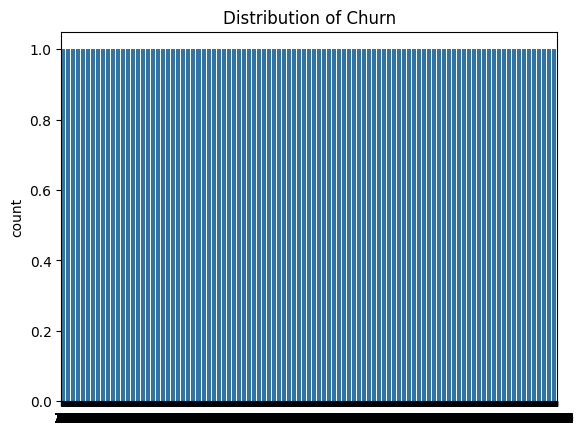

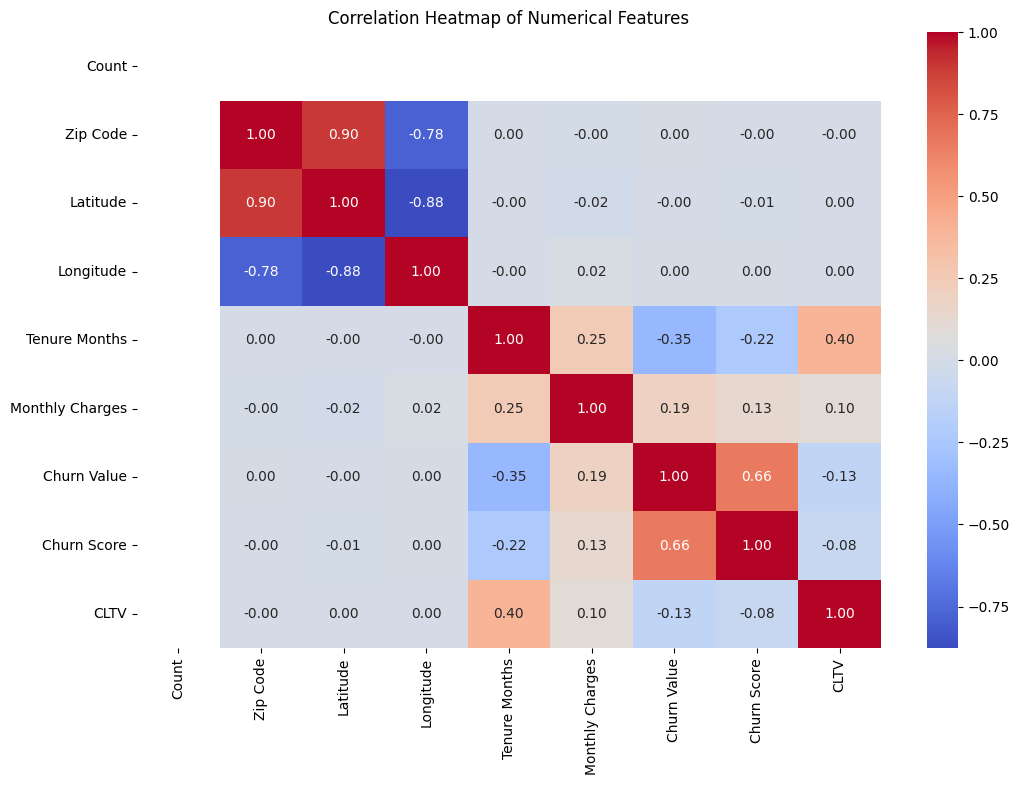

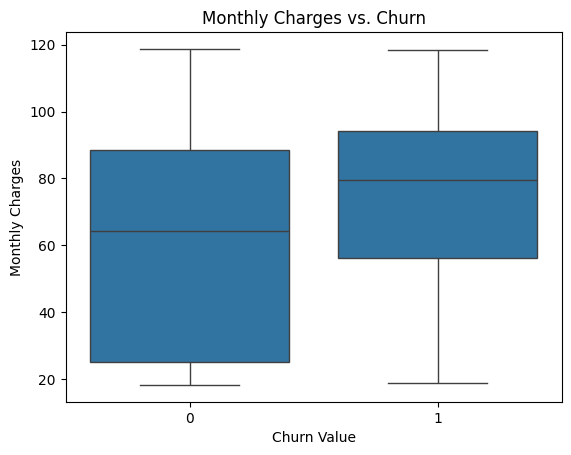

In [ ]:

# Distribution of target variable
sns.countplot(data[target])
plt.title("Distribution of Churn")
plt.show()

# Correlation heatmap for numerical features only
# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# Visualization: Relationship between 'Monthly Charges' and churn
sns.boxplot(x=target, y='Monthly Charges', data=data)
plt.title("Monthly Charges vs. Churn")
plt.show()

# Feature Engineering

In [ ]:
# Creating a "TotalSpending" feature

# Feature selection
# Using correlation or feature importance scores from tree-based models can help here.
if 'MonthlyCharges' in data.columns and 'tenure' in data.columns:
    X['TotalSpending'] = data['MonthlyCharges'] * data['tenure']

# Model Selection and Training

In [ ]:
# Initialize classifiers
logistic_model = LogisticRegression(class_weight='balanced', random_state=42)
decision_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train Logistic Regression as a baseline
logistic_model.fit(X_train, y_train)

# Train Decision Tree model
decision_tree.fit(X_train, y_train)

# Train Random Forest model
random_forest.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

# Model Evaluation

In [ ]:
# Predictions and Evaluation for Logistic Regression
y_pred_logistic = logistic_model.predict(X_test)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_logistic))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))

# AUC-ROC for Logistic Regression
y_pred_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob_logistic)
print("AUC-ROC for Logistic Regression:", roc_auc)

# Repeat evaluation steps for Decision Tree and Random Forest
models = {'Decision Tree': decision_tree, 'Random Forest': random_forest}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{model_name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC for {model_name}:", roc_auc)

# Cross-validation with Random Forest as an example
cv_scores = cross_val_score(random_forest, X, y, cv=5, scoring='roc_auc')
print("Random Forest CV AUC-ROC:", np.mean(cv_scores))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1009
           1       1.00      1.00      1.00       400

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409

Confusion Matrix:
 [[1009    0]
 [   0  400]]
AUC-ROC for Logistic Regression: 1.0
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1009
           1       1.00      1.00      1.00       400

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409

Decision Tree Confusion Matrix:
 [[1009    0]
 [   0  400]]
AUC-ROC for Decision Tree: 1.0
Random Forest Classification Report:
              precision    recall  f1-score   support

           0   

# Hyperparameter Tuning

In [ ]:
# Grid Search for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("Best parameters from Grid Search:", grid_search.best_params_)
print("Best CV score from Grid Search:", grid_search.best_score_)

# Update model to the best estimator
best_model = grid_search.best_estimator_

Best parameters from Grid Search: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score from Grid Search: 1.0


# Save the Model

In [ ]:
import joblib
# Save the final model
joblib.dump(best_model, 'final_churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')  # Save scaler to use in production